## TESTING MONTE CARLO SIMULATIONS

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import display
from yahoo_fin import options
from yahoo_fin import stock_info as si
import scipy.optimize as scpo
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
plt.style.use('default')
pio.templates.default = "seaborn"

from functions.BSpricer import BS_Pricer
from functions.MERTONpricer import Merton_pricer
from functions.KOUpricer import Kou_pricer
from functions.VGpricer import VG_pricer

np.random.seed(27)

In [2]:
T = 1  # Expiry Date in years
days = 252
paths = 10000
r = 0.03 # risk.free interest rate
q = 0
size = (days, paths)
exercise = 'european'

### CALLS CALIBRATED PARAMETERS

In [3]:
spx_data = pd.read_csv('data/sp500_data.csv')
print(spx_data.head())


         Date         Open         High          Low        Close      Volume   
0  2016-01-20  1876.180054  1876.180054  1812.290039  1859.329956  6416070000  \
1  2016-01-21  1861.459961  1889.849976  1848.979980  1868.989990  5078810000   
2  2016-01-22  1877.400024  1908.849976  1877.400024  1906.900024  4901760000   
3  2016-01-25  1906.280029  1906.280029  1875.969971  1877.079956  4401380000   
4  2016-01-26  1878.790039  1906.729980  1878.790039  1903.630005  4357940000   

    Returns  Log Returns  Returns (%)  
0       NaN          NaN          NaN  
1  1.005195     0.005182     0.519544  
2  1.020284     0.020081     2.028370  
3  0.984362    -0.015762    -1.563798  
4  1.014144     0.014045     1.414434  


In [4]:
bs_sigma = 0.1491  # [σ]

#mert_params = [0.1141, 0.42, -0.22, 0.3394]
# mert_params = [ 0.11156,  0.9275, -0.0795,  0.0848 ]
# mert_params = [0.0878, 0.9085, -0.118, 0.0963]  # [σ, λ, m, v]
#mert_params2 = [0.0713, 0.7368, -0.1748, 0.0]
#mert_params3 = [0.085, 0.912, -0.1226, 0.0936]       # calibrazione data 31/07/2023
#mert_params = [0.0909, 0.4634, -0.1892, 0.1374]     # calibrazione data 6/8/23
#mert_params = [0.0879, 0.4824, -0.196, 0.1228]
#mert_params = [0.0962, 0.2183, -0.3505, 0.0576]         # calibrazione data 6/8/23
#mert_params = [0.0967, 0.2132, -0.36, 0.1317]
#mert_params = [0.1009, 0.2026, -0.2832, 0.1202]         # calibrazione del 7/8/23 (CALL)
#mert_params = [0.1774, 1.1306, -0.13, 0.182]            # calibrazione 7/8/23 (PUT)
#mert_params = [0.1267, 0.951, -0.1182, 0.2691]          # calibrazione 8/8/23 (PUT)
#mert_params = [0.0858, 0.4945, -0.1739, 0.1004]         # calibrazione 10/8/23 (CALLS)
mert_params = [0.1205, 0.4862, -0.0381, 0.0481]         #calibrazione 16/8/23

# kou_params = [0.21022, 0.04, 0.4, 0.0, 15.0]        # [σ, λ, p, η_1, η_2]
# kou_params = [0.0863, 1.2065, 0.4, 9.8519, 10.0]
# kou_params = [0.1233, 0.2608, 0.1961, 6.2507, 6.1967]
# kou_params = [0.12, 0.4296, 0.2498, 13.0534, 6.5574]
# kou_params = [0.0932, 0.361, 0.2877, 3.5685, 4.2118]
# kou_params = [0.0976, 0.2195, 0.2574, 11.8654, 2.0341]    # ultima calibrazione data 31/07/2023
# kou_params = [0.0888, 0.2883, 0.2506, 12.04, 2.3913]
# kou_params = [0.1556, 1.1274, 0.3878, 14.3817, 4.4284]     #calibrazione del 7/8/23 con weighted PUTS
# kou_params = [0.1218, 1.2236, 0.3447, 7.6064, 4.7826]       # calibrazione
# kou_params = [0.1556, 1.1274, 0.3878, 14.3817, 4.4284]      # calibrazione 10/8/23 (CALLS)
kou_params = [0.1192, 0.162, 0.0647, 9.024, 10.8228]        # calibrazione 16/8/23


# vg_params= [0.14575, 0.11985, 0.41850]
# vg_params = [0.2633, -0.1039, 0.0138]                   # [σ, θ, v]
# vg_params = [0.151, 0.0107, 0.0909]  #### LAST CALIBRATION; GOOD
#vg_params = [0.1259, 0.1921, 0.3751]
#vg_params = [0.2458, 0.1976, 0.921] # calibrazione 7/8/23 PUTS
vg_params = [0.113, 0.1937, 0.3326]                     # calibrazione 16/8/23 (CALLS)

S0 = spx_data.loc[0, 'Close']
symbol = 'SPX'
#### Historical data from SPX Time Series (2016-2018)

In [5]:
otko_spx = pd.read_csv('data/otko_spx_1year.csv')

th_prices = pd.DataFrame({
    'K1': otko_spx['K1'],
    'K2': otko_spx['K2'],
    'Midpoint (%)': otko_spx['Midpoint (%)']
})

strikes = otko_spx[['K1', 'K2']].values / 100

### Black Scholes

(252, 10000)


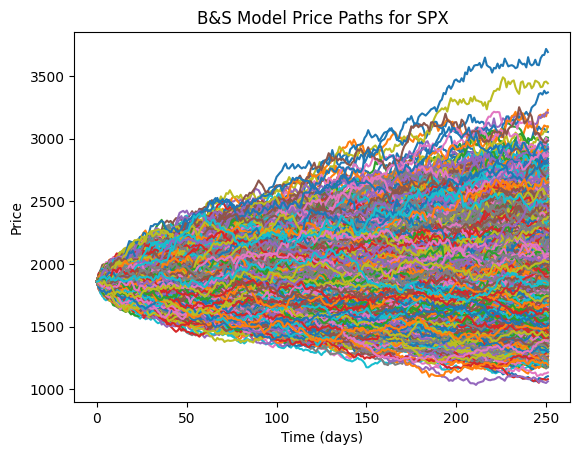

<Figure size 1000x600 with 0 Axes>

In [6]:
BS = BS_Pricer(S0, r, q, bs_sigma, T, exercise, None)
SBlackScholes = BS.BlackScholesPath(days, paths)
BS.plotBSPath(SBlackScholes, symbol)
print(SBlackScholes.shape)

### Merton

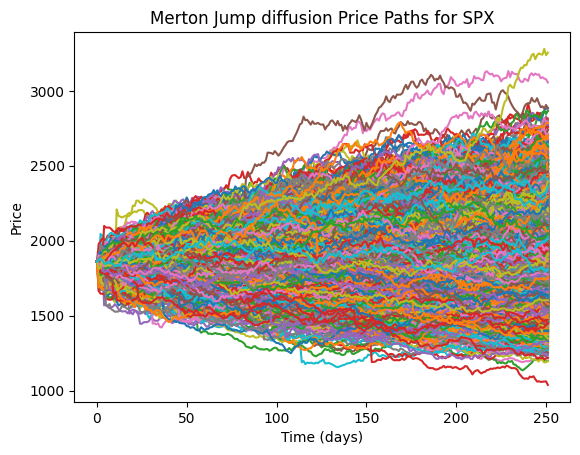

<Figure size 1000x600 with 0 Axes>

In [7]:
# #mert_params = [0.085, 0.912, -0.1226, 0.0936]
# #mert_params = [0.0909, 0.4634, -0.1892, 0.1374]
# mert_params = [0.0898, 0.4648, -0.1864, 0.1384]
MERT = Merton_pricer(S0, None, T, r, q, mert_params[0], mert_params[1], mert_params[2], mert_params[3], exercise)

SMerton = MERT.MertonPath(days, paths)
MERT.plotMertonPath(SMerton, symbol)  # Plot all paths

### Kou JD

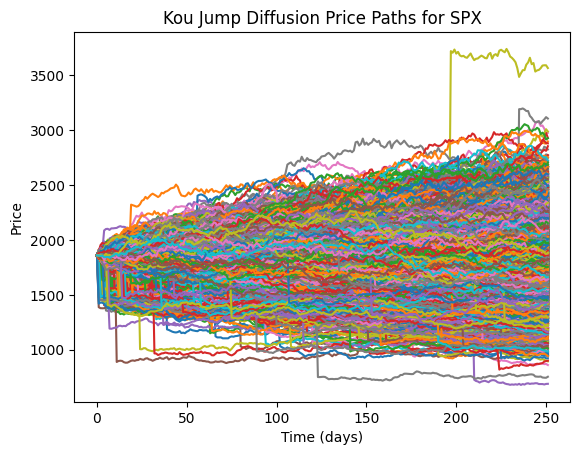

<Figure size 1000x600 with 0 Axes>

In [17]:
# #kou_params = [0.1247, 0.114, 0.3507, 2.4654, 10.0165]
# kou_params0 = [0.1447, 0.19, 0.4229, 2.15, 7.75]
# kou_params1 = [0.1047, 0.247, 0.383, 2.0013, 6.3471]
#kou_params = [0.1047, 0.2704, 0.3919, 2.25, 7.4077]
# kou_params3 = [0.0647, 0.19, 0.401, 2.25, 7.0253]
# kou_params =
#kou_params = [0.23, 7.04, 0.515, 13.072, 24.155]        # from TANKOV paper
#kou_params = [0.1247, 0.4346, 0.7228, 10.3, 5.5155]
#kou_params = [0.115, 0.4313, 0.5324, 10.3, 7.5159]
#kou_params = [0.115, 0.4313, 0.5324, 12.3, 7.5159]

KOU = Kou_pricer(S0,None, T, r, kou_params[0], kou_params[1], kou_params[2], kou_params[3], kou_params[4], exercise)
SKou = KOU.KouPath(days, paths)

# Plot all paths
KOU.plotKouPath(SKou, symbol)

In [18]:
avg_final_value = SKou[-1,:].mean()
print(f'KOU Jump Diffusion SPX value after 252 days: {avg_final_value}')

# Pass one by one path to the otko_payoff function. Returns an array of size (paths)
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SKou.T:
        payoffs.append(KOU.payoff_otko(path,K1, K2))
    avg_payoffs.append(np.mean(payoffs))


kou_mc_prices = np.zeros(len(th_prices))
kou_prices_cf = np.zeros(len(th_prices))
for index in range(len(th_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
for i, (K1, K2) in enumerate(zip(otko_spx['K1'].values, otko_spx['K2'].values)):
    kou_prices_cf[i] =KOU.closed_formula_otko(K1/100, K2/100)

th_prices['KOU CF (%)'] = kou_prices_cf
th_prices['KOU MC (%)'] = kou_mc_prices
print(th_prices)


KOU Jump Diffusion SPX value after 252 days: 1887.8823799023376
   K1  K2  Midpoint (%)  KOU CF (%)  KOU MC (%)  VG CF (%)  VG MC (%)
0  75   0         0.185    0.039141    0.052374   0.168324   0.171474
1  70   0         0.090    0.017321    0.028762   0.072527   0.074629
2  85  75         0.370    0.132656    0.660108   0.650066   0.660921
3  80  70         0.260    0.066607    0.254133   0.305190   0.311513
4  90  80         0.510    0.253637    0.985201   1.332358   1.351396


### Variance gamma

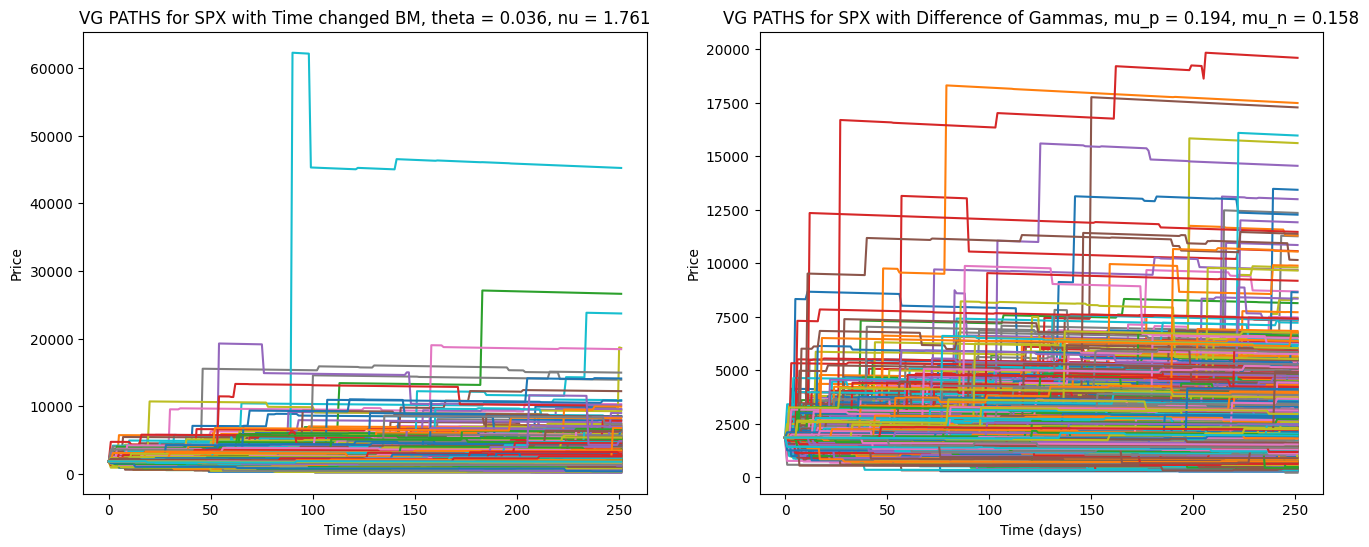

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [19]:
# vg_params = [0.3, -0.01, 0.2]
sigma, theta, nu = vg_params

VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
SVarGamma = VG.VarianceGammaPath1(days, paths)
SVarGamma2 = VG.VarianceGammaPath2(days, paths)

method = ['Time changed BM', 'Difference of Gammas']

# Plot all paths
fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
VG.plotVGPath(SVarGamma, symbol, method[0], ax=axes[0])
VG.plotVGPath(SVarGamma2, symbol, method[1], ax=axes[1])
plt.tight_layout()

In [20]:
avg_final_value = SVarGamma[251,:].mean()
print(f'VG Jump Diffusion SPX value after 252 days: {avg_final_value}')

# Pass one by one path to the otko_payoff function. Returns an array of size (paths)
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SVarGamma2.T:
        payoffs.append(VG.payoff_otko(path,K1, K2))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(th_prices))
vg_prices_cf = np.zeros(len(th_prices))

for index in range(len(th_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]*100
for i, (K1, K2) in enumerate(zip(otko_spx['K1'].values, otko_spx['K2'].values)):
    vg_prices_cf[i] = VG.closed_formula_otko6(K1/100, K2/100)

th_prices['VG CF (%)'] = vg_prices_cf
th_prices['VG MC (%)'] = vg_mc_prices
print(th_prices)

VG Jump Diffusion SPX value after 252 days: 1924.2879668068967
   K1  K2  Midpoint (%)  KOU CF (%)  KOU MC (%)  VG CF (%)  VG MC (%)
0  75   0         0.185    0.039141    0.052374   1.291615   1.271398
1  70   0         0.090    0.017321    0.028762   0.856249   0.858604
2  85  75         0.370    0.132656    0.660108   1.566845   1.533989
3  80  70         0.260    0.066607    0.254133   1.092552   1.051098
4  90  80         0.510    0.253637    0.985201   2.227341   2.164441


The maximum number of function evaluations is exceeded.
Function evaluations 300, initial cost 5.0428e+03, final cost 2.7569e+00, first-order optimality 5.53e+01.
METHOD 1: LEAST-SQUARES (trf)
> Calibrated Volatlity [σ] = 0.1216, 	 12.16%
> Calibrated mean rate gamma process [θ] =  -0.0843
> Calibrated variance rate gamma process [v]=  0.715
CALIBRATED PARAMETERS: [σ 		θ		 v]
> European CALLS:	 [0.3285, 0.036, 1.7612]
> OTKO DC:			 [0.1216, -0.0843, 0.715]


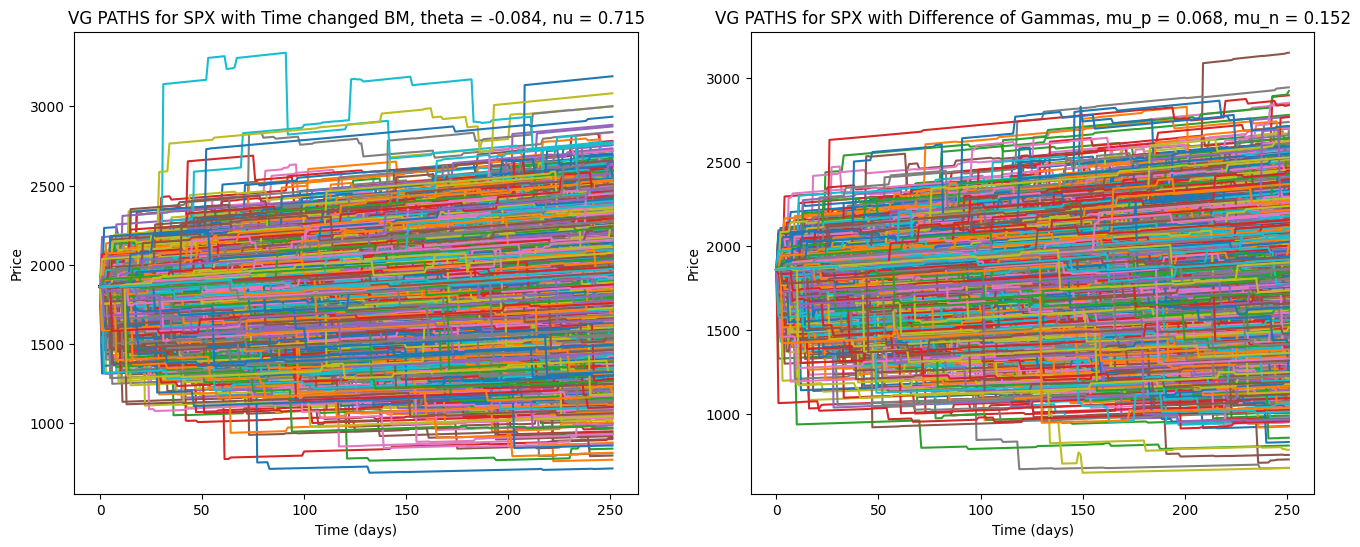

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [21]:
x0 = [0.2, -0.2, 0.02] # initial guess: [σ, θ, v]
#x0 = vg_params
bounds = ([1e-3, -5, 0], [0.6, 0.4, 4])
spreads =  otko_spx['ASK(%)'] - otko_spx['BID(%)']
weights = 1/spreads**2
mkt_prices = otko_spx['Midpoint (%)'].values

def cost_function(x, strikes, mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    sq_err = 0
    for k in [0,1,3]:
        sq_err += weights[k] * (VG.closed_formula_otko6(strikes[k][0], strikes[k][1]) - mkt_prices[k]) ** 2
    return sq_err

vg = scpo.least_squares(cost_function, x0, args=(strikes, mkt_prices), method='trf', bounds=bounds, verbose=1)

vg_params_calibrated = [round(p, 4) for p in vg.x[:3]]
print('METHOD 1: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params_calibrated[0]}, \t {round(vg_params_calibrated[0] * 100, 2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params_calibrated[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params_calibrated[2])
print(f'CALIBRATED PARAMETERS: [σ \t\tθ\t\t v]')
print(f'> European CALLS:\t {vg_params}')
print(f'> OTKO DC:\t\t\t {vg_params_calibrated}')
sigma, theta, nu = vg_params_calibrated

VG_CAL = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
SVarGamma_cal = VG_CAL.VarianceGammaPath1(days, paths)
SVarGamma2_cal = VG_CAL.VarianceGammaPath2(days, paths)

method = ['Time changed BM', 'Difference of Gammas']

# Plot all paths
fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
VG_CAL.plotVGPath(SVarGamma_cal, symbol, method[0], ax=axes[0])
VG_CAL.plotVGPath(SVarGamma2_cal, symbol, method[1], ax=axes[1])
plt.tight_layout()


In [22]:
# Pass one by one path to the otko_payoff function. Returns an array of size (paths)
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SVarGamma2_cal.T:
        payoffs.append(VG_CAL.payoff_otko(path,K1, K2))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(th_prices))
vg_prices_cf = np.zeros(len(th_prices))

for index in range(len(th_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]*100
for i, (K1, K2) in enumerate(zip(otko_spx['K1'].values, otko_spx['K2'].values)):
    vg_prices_cf[i] = VG_CAL.closed_formula_otko6(K1/100, K2/100)

th_prices['VG CF (%)'] = vg_prices_cf
th_prices['VG MC (%)'] = vg_mc_prices
print(th_prices)

   K1  K2  Midpoint (%)  KOU CF (%)  KOU MC (%)  VG CF (%)  VG MC (%)
0  75   0         0.185    0.039141    0.052374   0.168324   0.140540
1  70   0         0.090    0.017321    0.028762   0.072527   0.057560
2  85  75         0.370    0.132656    0.660108   0.650066   0.642584
3  80  70         0.260    0.066607    0.254133   0.305190   0.283252
4  90  80         0.510    0.253637    0.985201   1.332358   1.347229


In [23]:
# Day-by-day mean of the 1000 paths, for each model
daily_avg = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou', 'VarGamma1', 'VarGamma2'])
#daily_avg['Days'] = np.linspace(0,251,1)

daily_avg['BlackScholes'] = SBlackScholes.mean(axis=1)
daily_avg['Merton'] = SMerton.mean(axis=1)
daily_avg['Kou'] = SKou.mean(axis=1)
daily_avg['VarGamma1'] = SVarGamma.mean(axis=1)
daily_avg['VarGamma2'] = SVarGamma2.mean(axis=1)
print(daily_avg.tail())



     BlackScholes       Merton          Kou    VarGamma1    VarGamma2
247   1911.238293  1919.322466  1887.269223  1922.960125  1911.959183
248   1912.150270  1919.139346  1887.624217  1923.441947  1912.429094
249   1912.404312  1918.674126  1887.594671  1922.709694  1911.970547
250   1912.213590  1918.210696  1887.709107  1924.743878  1911.568460
251   1913.185193  1918.148067  1887.882380  1924.287967  1912.120524


In [24]:
# TODO: COSA è LA DERIVA VERSO IL BASSO? controlla formule
St = S0 * np.exp(r * T)
print(St)

# Calculate the daily growth factor
daily_growth_factor = np.exp(r/ days)

# Calculate the growth of prices day by day
St = S0 * np.cumprod(np.full(days, daily_growth_factor))

fig1 = go.Figure()
for column in daily_avg.columns:
    fig1.add_trace(go.Scatter(x=spx_data.loc[0:251, 'Date'], y=daily_avg[column], name=column))
fig1.add_trace(go.Scatter(x = spx_data.loc[0:251, 'Date'], y = St, name='Risk-free Growth'))

# Update the layout
fig1.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title = 'Real vs Simulated SPX paths',
    showlegend=True
)

# Show the plot
pio.show(fig1)

### MERTON DRIFT!!!
### CAPIRE KOU e VG come aggiustare drift

1915.9549833321462


### PUTS CALIBRATION. MODEL VALIDATION CHECK

In [14]:
spx_data = pd.read_csv('data/sp500_data.csv')
print(spx_data.head())
bs_sigma = 0.3361  # [σ]

# MERTON MODEL
#mert_params = [0.1774, 1.1306, -0.13, 0.182]            # calibrazione 7/8/23 (PUT)
#mert_params = [0.1267, 0.951, -0.1182, 0.2691]          # calibrazione 8/8/23 (PUT)
mert_params = [0.0873, 0.9186, -0.0375, 0.322]          # calibrazione 16/8/23

# KOU MODEL
#kou_params = [0.1556, 1.1274, 0.3878, 14.3817, 4.4284]     #calibrazione del 7/8/23 con weighted PUTS
#kou_params = [0.1218, 1.2236, 0.3447, 7.6064, 4.7826]       # calibrazione 8/8/23 (PUT)
# kou_params = [0.0833, 0.9776, 0.3201, 5.2527, 4.2792]       # calibrazione 10/10/23
kou_params = [0.0358, 1.0469, 0.0942, 2.2675, 5.2646]         # calibrazione 16/10/23

# VARIANCE GAMMA MODEL
#vg_params = [0.2458, 0.1976, 0.921]                         # calibrazione 7/8/23 PUTS
vg_params = [0.3285, 0.036, 1.7612]                         # calibrazione 16/10/23

S0 = spx_data.loc[0, 'Close']
symbol = 'SPX'

         Date         Open         High          Low        Close      Volume   
0  2016-01-20  1876.180054  1876.180054  1812.290039  1859.329956  6416070000  \
1  2016-01-21  1861.459961  1889.849976  1848.979980  1868.989990  5078810000   
2  2016-01-22  1877.400024  1908.849976  1877.400024  1906.900024  4901760000   
3  2016-01-25  1906.280029  1906.280029  1875.969971  1877.079956  4401380000   
4  2016-01-26  1878.790039  1906.729980  1878.790039  1903.630005  4357940000   

    Returns  Log Returns  Returns (%)  
0       NaN          NaN          NaN  
1  1.005195     0.005182     0.519544  
2  1.020284     0.020081     2.028370  
3  0.984362    -0.015762    -1.563798  
4  1.014144     0.014045     1.414434  


#### Monte Carlo Paths Simulation of all the models

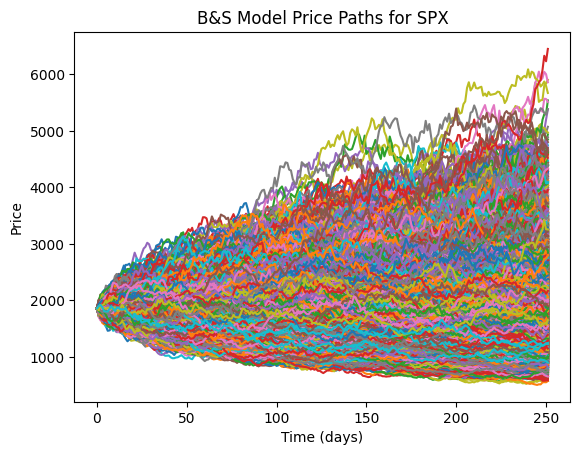

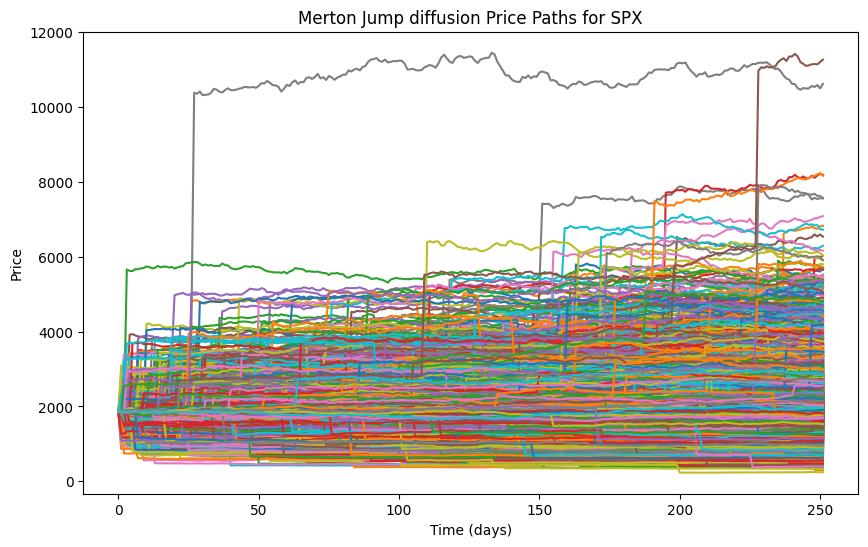

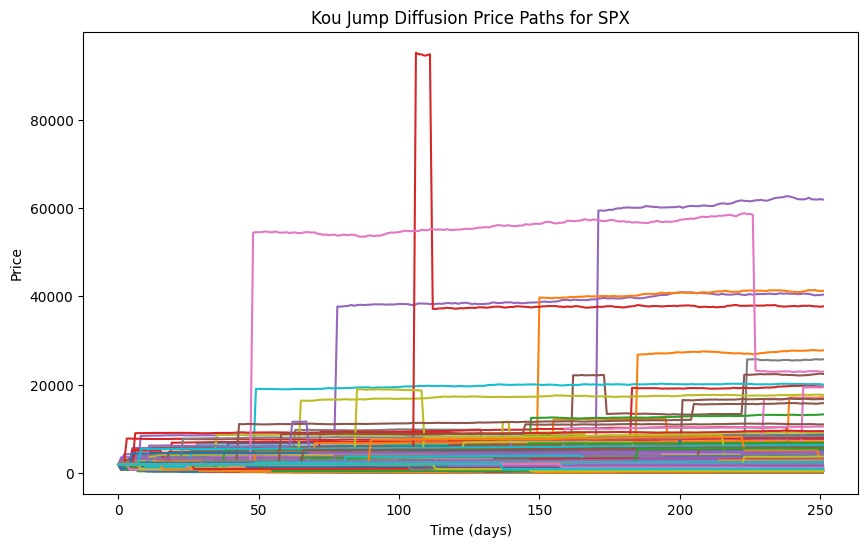

<Figure size 1000x600 with 0 Axes>

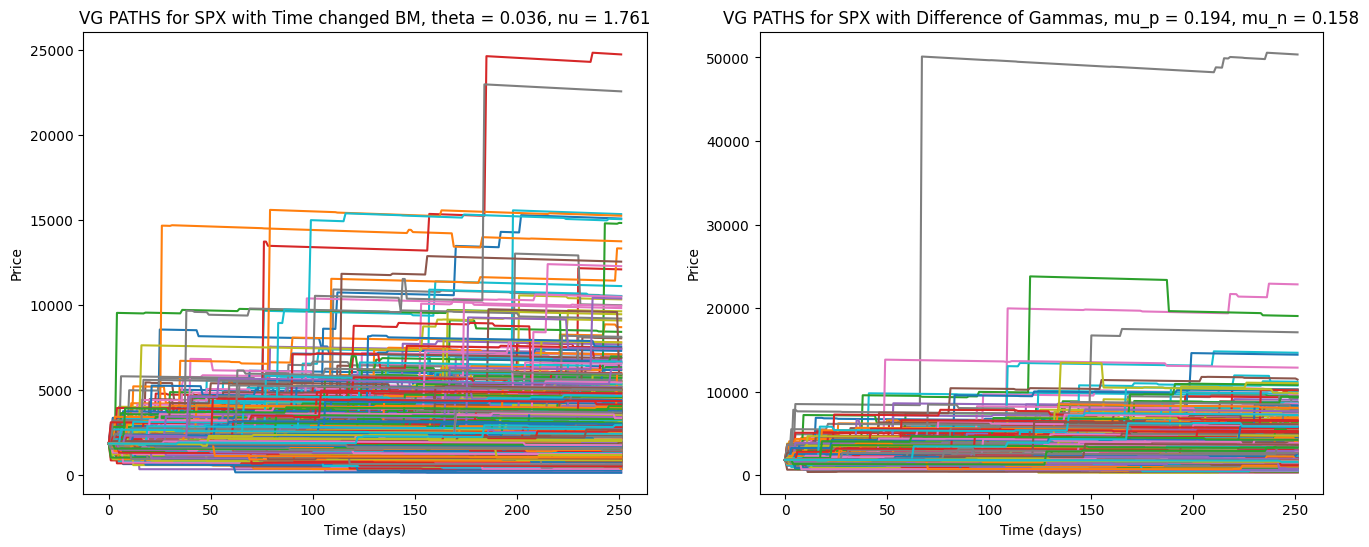

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [15]:
days = 252
paths = 10000

# BLACK SCHOLES
BS = BS_Pricer(S0, r, q, bs_sigma, T, exercise, None)
SBlackScholes = BS.BlackScholesPath(days, paths)
BS.plotBSPath(SBlackScholes, symbol)

# MERTON MODEL
MERT = Merton_pricer(S0, None, T, r, q, mert_params[0], mert_params[1], mert_params[2], mert_params[3], exercise)
SMerton = MERT.MertonPath(days, paths)
MERT.plotMertonPath(SMerton, symbol)  # Plot all paths

# KOU MODEL
KOU = Kou_pricer(S0,None, T, r, kou_params[0], kou_params[1], kou_params[2], kou_params[3], kou_params[4], exercise)
SKou = KOU.KouPath(days, paths)
KOU.plotKouPath(SKou, symbol)

# VARIANCE GAMMA
sigma, theta, nu = vg_params
VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
SVarGamma = VG.VarianceGammaPath1(days, paths)
SVarGamma2 = VG.VarianceGammaPath2(days, paths)

method = ['Time changed BM', 'Difference of Gammas']

# Plot all paths
fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
VG.plotVGPath(SVarGamma, symbol, method[0], ax=axes[0])
VG.plotVGPath(SVarGamma2, symbol, method[1], ax=axes[1])
plt.tight_layout()


In [16]:
# Day-by-day mean of the 1000 paths, for each model
daily_avg = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou', 'VarGamma1', 'VarGamma2'])
#daily_avg['Days'] = np.linspace(0,251,1)

daily_avg['BlackScholes'] = SBlackScholes.mean(axis=1)
daily_avg['Merton'] = SMerton.mean(axis=1)
daily_avg['Kou'] = SKou.mean(axis=1)
daily_avg['VarGamma1'] = SVarGamma.mean(axis=1)
daily_avg['VarGamma2'] = SVarGamma2.mean(axis=1)
print(daily_avg.tail())
# TODO: COSA è LA DERIVA VERSO IL BASSO? controlla formule
St = S0 * np.exp(r * T)
print(St)

# Calculate the daily growth factor
daily_growth_factor = np.exp(r / days)

# Calculate the growth of prices day by day
St = S0 * np.cumprod(np.full(days, daily_growth_factor))

fig1 = go.Figure()
for column in daily_avg.columns:
    fig1.add_trace(go.Scatter(x=spx_data.loc[0:251, 'Date'], y=daily_avg[column], name=column))
fig1.add_trace(go.Scatter(x = spx_data.loc[0:251, 'Date'], y = St, name='Risk-free Growth'))

# Update the layout
fig1.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title = 'Real vs Simulated SPX paths',
    showlegend=True
)

# Show the plot
pio.show(fig1)

### MERTON DRIFT!!!
### CAPIRE KOU e VG come aggiustare drift

     BlackScholes       Merton          Kou    VarGamma1    VarGamma2
247   1911.238293  1919.322466  1454.104782  1920.509870  1934.951969
248   1912.150270  1919.139346  1452.142324  1921.137504  1935.440009
249   1912.404312  1918.674126  1451.508880  1922.197389  1935.572573
250   1912.213590  1918.210696  1449.536365  1922.055198  1935.246570
251   1913.185193  1918.148067  1448.262950  1921.904853  1935.079704
1915.9549833321462
